## Read Files

In [16]:
import pandas as pd
import os

# Files to use for the analysis

# detected_bugs_file = os.path.join('detected_bugs_3.csv')
folder = os.path.join("results")

projects_ranking_file = os.path.join('jmh-projects-bigquery-fh-201702 - jmh-projects-gh.csv')

top = 25

projects = pd.read_csv(projects_ranking_file, sep=',')


# Normalize columns
projects['xml'] = projects['project'].apply(lambda x: x.split('/')[1] + '.xml')
projects['name'] = projects['project'].apply(lambda x: x.split('/')[1])


In [17]:
# Normalizing the plot colors
COLOR = 'cornflowerblue'
COLOR = 'lightskyblue'
ALPHA = .8

## Remove Projects that could not be analyzed

In [18]:
# Remove projects that could not be analyzed
projects_to_remove = ['jgrapht/jgrapht', 'lemire/RoaringBitmap', 'RoaringBitmap/RoaringBitmap', 
                      'requery/requery', 'Netflix/feign', 'crate/crate', 'real-logic/simple-binary-encoding', 
                      'jbachorik/btrace', 'promeG/TinyPinyin', 'pcollections/pcollections', 'ktoso/sbt-jmh', 
                      'junkdog/artemis-odb', 'fakemongo/fongo', 'graalvm/truffle', 'graalvm/graal-core']

projects = projects[~projects['project'].isin(projects_to_remove)] # jgrapht

top_projects = projects.sort_values(by=['watchers', 'stars', 'forks'], ascending=False)

### Remove Forked Projects

In [19]:
non_duplicated_projects = top_projects[top_projects.forked == False]
print('Original Set containing %d projects' % len(top_projects))
print('Non-forked projects containing %d projects' % len(non_duplicated_projects))

Original Set containing 824 projects
Non-forked projects containing 506 projects


## Analyze the bugs based on the Type reported

In [20]:
from collections import Counter
import xml.etree.ElementTree as ET

def analyzeBugTypes(df):
    
    try:
    
        tree = ET.parse(os.path.join(folder, df['xml']))
        root = tree.getroot()

        all_bugs = root.findall('BugInstance')

        bugs_per_type = [] 
        for b in all_bugs:
            bug_type = b.get('type')
            clazz = b.find('Class')
            if clazz and 'generated' not in clazz.get('classname'):
                bugs_per_type.append(bug_type)

        # Count bugs per type
        bugs = Counter(bugs_per_type)
        for key, value in bugs.items():
            df[key] = value
    
    except FileNotFoundError:
        pass
    
    return df

analyzed = non_duplicated_projects.apply(analyzeBugTypes, axis=1)
analyzed = analyzed.fillna(0)
analyzed = analyzed.set_index('name')
analyzed = analyzed[analyzed['JMH_BENCHMARK_METHOD_FOUND'] > 0]

columns_to_export = [
   'stars',
   'forks',
    'subscribers',
    'watchers',
    'JMH_BENCHMARK_METHOD_FOUND',
    'JMH_FIXTURE_USING_INVOCATION_SCOPE',
    'JMH_NOTFORKED_BENCHMARK',
#    'JMH_BENCHMARKMODE_SINGLESHOT',
   # 'JMH_UNSINKED_VARIABLE',
    'JMH_DEAD_STORE_VARIABLE',
    'JMH_IGNORED_STATIC_METHOD_RETURN',
    'JMH_IGNORED_STATIC_PRIMITIVE_METHOD_RETURN',
    'JMH_STATE_FINAL_PRIMITIVE',
    'JMH_UNSAFELOOP_INSIDE_BENCHMARK',
    #'JMH_STATE_FINAL_STATIC_PRIMITIVE',
]


bug_type_dict = {
    'stars': 'Stars',
    'forks': 'Forks',
    'subscribers': 'Subs',
    'JMH_BENCHMARK_METHOD_FOUND': 'Benchs',
    'JMH_FIXTURE_USING_INVOCATION_SCOPE': 'INVO',
    'JMH_IGNORED_METHOD_RETURN': 'RETU',
    'JMH_UNSAFELOOP_INSIDE_BENCHMARK': 'LOOP',
    'JMH_STATE_FINAL_FIELD': 'FINA',
    'JMH_NOTFORKED_BENCHMARK': 'FORK',
#    'JMH_BENCHMARKMODE_SINGLESHOT': 'SING',
#    'JMH_UNSINKED_VARIABLE': 'UNSINK',
    'JMH_DEAD_STORE_VARIABLE': 'DEAD',
    'JMH_IGNORED_STATIC_METHOD_RETURN': 'STAT',
    'JMH_IGNORED_STATIC_PRIMITIVE_METHOD_RETURN': 'STAT2',
    
    'JMH_STATE_FINAL_PRIMITIVE': 'FINA',
    
}

analyzed = analyzed[columns_to_export]
analyzed = analyzed.rename(columns=bug_type_dict)


### Droping some duplicates

For some reasons our set contains some projects multiple times.

In [21]:
analyzed = analyzed.sort_values(by='Stars', ascending=False)
print(len(analyzed))

print("Removing the following projects")
print(analyzed[analyzed.index.duplicated(keep='first')].index)

# Remove the one with least amount of stars
analyzed = analyzed[~analyzed.index.duplicated(keep='first')]
print(len(analyzed))


133
Removing the following projects
Index(['javaslang-circuitbreaker', 'rapidpm-microservice', 'netty',
       'microbenchmarks', 'java', 'java', 'microbenchmarks', 'rtree',
       'airlift', 'microbenchmarks'],
      dtype='object', name='name')
123


In [22]:
analyzed.head()

,Stars,Forks,Subs,watchers,Benchs,INVO,FORK,DEAD,STAT,STAT2,FINA,LOOP
name,,,,,,,,,,,,
RxJava,23558,4143,1754,23558,215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
netty,9746,4775,1243,9746,159.0,2.0,0.0,0.0,10.0,0.0,2.0,14.0
zipkin,5627,851,507,5627,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
druid,4743,1132,457,4743,148.0,2.0,0.0,0.0,0.0,0.0,1.0,11.0
okio,3703,601,220,3703,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Dataset Exploration 

### Stars

In [23]:
import seaborn as sns
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

sns.set(font_scale=1.2)
plt.figure(figsize=(6,4))
sns.set_style("ticks")

starbins=[0,10,25,50,100,500,50000]

stars = pd.cut(analyzed['Stars'], bins=starbins).value_counts()
ax = sns.barplot(x=stars.index, y=stars, color=COLOR, alpha=ALPHA)

ax.xaxis.set_major_formatter(ticker.FixedFormatter(['<10', '11-25','26-50','51-100','101-500','>500']))
ax.set(xlabel='# of Stars', ylabel='# of Projects')

plt.tight_layout()
plt.savefig(os.path.join(folder, 'projects-stars-distribution.pdf'))
plt.close()

### Watchers

In [24]:
sns.set(font_scale=1.2)
plt.figure(figsize=(6,4))
sns.set_style("ticks")

watchersbin=[0,10,25,50,100,500,50000]

watchers = pd.cut(analyzed['watchers'], bins=watchersbin).value_counts()
ax = sns.barplot(x=watchers.index, y=watchers, color=COLOR, alpha=ALPHA)

ax.xaxis.set_major_formatter(ticker.FixedFormatter(['<10', '11-25','26-50','51-100','101-500','>500']))
ax.set(xlabel='# of Watchers', ylabel='# of Projects')

plt.tight_layout()
plt.savefig(os.path.join(folder, 'projects-watchers-distribution.pdf'))
plt.close()

### Forks

In [25]:
sns.set(font_scale=1.2)
plt.figure(figsize=(6,4))
sns.set_style("ticks")

forksbin=[0,10,25,50,100,500,50000]

forks = pd.cut(analyzed['Forks'], bins=watchersbin).value_counts()
ax = sns.barplot(x=forks.index, y=forks, color=COLOR, alpha=ALPHA)

ax.xaxis.set_major_formatter(ticker.FixedFormatter(['<10', '11-25','26-50','51-100','101-500','>500']))
ax.set(xlabel='# of Forks', ylabel='# of Projects')

plt.tight_layout()
plt.savefig(os.path.join(folder, 'projects-forks-distribution.pdf'))
plt.close()

### Subscribers

In [26]:
sns.set(font_scale=1.2)
plt.figure(figsize=(6,4))
sns.set_style("ticks")

subscribersbin=[0,10,25,50,100,500,50000]

subs = pd.cut(analyzed['Subs'], bins=subscribersbin).value_counts()
ax = sns.barplot(x=subs.index, y=subs, color=COLOR, alpha=ALPHA)

ax.xaxis.set_major_formatter(ticker.FixedFormatter(['<10', '11-25','26-50','51-100','101-500','>500']))
ax.set(xlabel='# of Subscribers', ylabel='# of Projects')

plt.tight_layout()
plt.savefig(os.path.join(folder, 'projects-subscribers-distribution.pdf'))
plt.close()

### Consolidate RETU anti-pattern

In [12]:
analyzed['RETU'] = analyzed['DEAD'] + analyzed['STAT2'] + analyzed['STAT']

## Latex (Tables) by Popularity

In [13]:
# Consolidate both STAT 
latex = analyzed.copy()

pd.options.display.float_format = '{:.0f}'.format

latex = latex.sort_values(by='Stars', ascending=False)

latex = latex[:top]
latex = latex.fillna('')
latex = latex.replace({0: ''})

order = ['Stars', 'Benchs', 'INVO', 'RETU', 'FINA', 'LOOP', 'FORK']

print(latex[order].to_latex())

\begin{tabular}{lrllllll}
\toprule
{} &  Stars & Benchs & INVO & RETU & FINA & LOOP & FORK \\
name                     &        &        &      &      &      &      &      \\
\midrule
RxJava                   &  23558 &    215 &      &      &      &      &      \\
netty                    &   9746 &    159 &    2 &   10 &    2 &   14 &      \\
zipkin                   &   5627 &     74 &      &      &      &      &      \\
druid                    &   4743 &    148 &    2 &      &    1 &   11 &      \\
okio                     &   3703 &     19 &    1 &      &      &      &      \\
grpc-java                &   2631 &      3 &      &      &      &      &      \\
caffeine                 &   2414 &     38 &      &    1 &      &      &      \\
h2o-3                    &   1943 &     18 &   10 &      &      &    6 &      \\
gs-collections           &   1652 &    451 &      &   47 &      &      &      \\
byte-buddy               &   1495 &     39 &      &      &      &      &      \\
pinot 

In [14]:
analyzed.loc['h2o-3']

Stars      1943
Forks       836
Subs        283
watchers   1943
Benchs       18
INVO         10
FORK          0
DEAD          0
STAT          0
STAT2         0
FINA          0
LOOP          6
RETU          0
Name: h2o-3, dtype: float64

In [15]:
analyzed.loc['benchmark-arraycopy']

Stars       2
Forks       1
Subs        1
watchers    2
Benchs     14
INVO        0
FORK        2
DEAD        0
STAT        0
STAT2       0
FINA        0
LOOP        0
RETU        0
Name: benchmark-arraycopy, dtype: float64

## Latex Table - By Amount of Benchmarks

In [16]:
# Consolidate both STAT 
latex = analyzed.copy()

pd.options.display.float_format = '{:.0f}'.format


latex = latex.sort_values(by='Benchs', ascending=False)

latex = latex[:top]
latex = latex.fillna('')
latex = latex.replace({0: ''})

order = ['Stars', 'Benchs', 'INVO', 'RETU', 'FINA', 'LOOP', 'FORK']

print(latex[order].to_latex())

\begin{tabular}{llllllll}
\toprule
{} &  Stars & Benchs & INVO & RETU & FINA & LOOP & FORK \\
name                                &        &        &      &      &      &      &      \\
\midrule
gs-collections                      &   1652 &    451 &      &   47 &      &      &      \\
logging-log4j2                      &    256 &    346 &      &    9 &    4 &    6 &      \\
RxJava                              &  23558 &    215 &      &      &      &      &      \\
oopsla15-artifact                   &     16 &    213 &   13 &    4 &    2 &    1 &    3 \\
netty                               &   9746 &    159 &    2 &   10 &    2 &   14 &      \\
reactive-streams-commons            &    106 &    157 &      &    2 &      &      &      \\
druid                               &   4743 &    148 &    2 &      &    1 &   11 &      \\
JCTools                             &   1053 &     92 &    2 &      &      &    1 &      \\
golo-jmh-benchmarks                 &      4 &     92 &      &      &

In [17]:
anti_patterns = ['INVO', 'FORK', 'RETU', 'FINA', 'LOOP']

def anti_pattern_category_analysis(df):
    cat = 0
    count = 0
    for ap in anti_patterns:
        if df[ap] > 0:
            cat = cat + 1
            count = count + df[ap]
    df['# of AP'] = count
    df['# of Categories'] = cat
    return df
    
df = analyzed.apply(anti_pattern_category_analysis, axis=1)
print('Analyzed Projects containing %d' % len(df))

Analyzed Projects containing 123


### Latex Table - By Density of Benchmarks

In [18]:
latex = df.copy()



pd.options.display.float_format = '{:.2f}'.format
latex['Density'] = latex['# of AP'] * 1.0 / latex['Benchs'] * 1.0

latex = latex.sort_values(by='Density', ascending=False)

latex = latex[:11]
latex = latex.fillna('')
latex = latex.replace({0: ''})

order = ['Stars', 'Benchs', 'Density','INVO', 'RETU', 'FINA', 'LOOP', 'FORK']

print(latex[order].to_latex())

\begin{tabular}{lllllllll}
\toprule
{} &   Stars & Benchs & Density &  INVO & RETU & FINA &  LOOP & FORK \\
name                  &         &        &         &       &      &      &       &      \\
\midrule
prairie               &    4.00 &  23.00 &    1.39 & 32.00 &      &      &       &      \\
jbender               &   95.00 &   1.00 &    1.00 &       & 1.00 &      &       &      \\
rest-schemagen        &   11.00 &   2.00 &    1.00 &       & 2.00 &      &       &      \\
audio-recognition     &    4.00 &   1.00 &    1.00 &       & 1.00 &      &       &      \\
geo                   &  182.00 &   2.00 &    1.00 &       & 2.00 &      &       &      \\
fixio                 &   43.00 &   1.00 &    1.00 &  1.00 &      &      &       &      \\
h2o-3                 & 1943.00 &  18.00 &    0.89 & 10.00 &      &      &  6.00 &      \\
expire-threadlocal    &    2.00 &   6.00 &    0.83 &       & 5.00 &      &       &      \\
safepoint-experiments &    5.00 &  18.00 &    0.67 &       & 1.0

### Latex Table - Density (> 10 benchmarks)

In [19]:
# Consolidate both STAT 
latex = df.copy()
latex = latex[latex.Benchs > 10]

pd.options.display.float_format = '{:.2f}'.format
latex['Density'] = latex['# of AP'] * 1.0 / latex['Benchs'] * 1.0

latex = latex.sort_values(by='Density', ascending=False)

latex = latex[:10]
latex = latex.fillna('')
latex = latex.replace({0: ''})

order = ['Stars', 'Benchs', 'Density','INVO', 'RETU', 'FINA', 'LOOP', 'FORK']

print(latex[order].to_latex())

\begin{tabular}{lllllllll}
\toprule
{} &   Stars & Benchs & Density &  INVO & RETU & FINA &  LOOP & FORK \\
name                  &         &        &         &       &      &      &       &      \\
\midrule
prairie               &    4.00 &  23.00 &    1.39 & 32.00 &      &      &       &      \\
h2o-3                 & 1943.00 &  18.00 &    0.89 & 10.00 &      &      &  6.00 &      \\
safepoint-experiments &    5.00 &  18.00 &    0.67 &       & 1.00 &      & 11.00 &      \\
jmh-samples           &   48.00 &  19.00 &    0.58 &       &      & 6.00 &  5.00 &      \\
java-benchmarks       &    2.00 &  17.00 &    0.53 &       &      &      &  9.00 &      \\
pinot                 & 1475.00 &  31.00 &    0.52 &       &      &      & 16.00 &      \\
xodus                 &  248.00 &  66.00 &    0.38 & 18.00 &      &      &  7.00 &      \\
microbenchmarks       &    7.00 &  67.00 &    0.33 &       &      & 5.00 & 17.00 &      \\
viktor                &    4.00 &  27.00 &    0.22 &       &    

### Project Distribution Analysis

Anti-patterns category distribution across different projects.

In [20]:
counts = df['# of Categories'].value_counts()
# General
print(counts.to_latex())

\begin{tabular}{lr}
\toprule
{} &  \# of Categories \\
\midrule
0.00 &               88 \\
1.00 &               24 \\
2.00 &                7 \\
3.00 &                2 \\
5.00 &                1 \\
4.00 &                1 \\
\bottomrule
\end{tabular}



In [21]:
large_df = df[df.Benchs > 10]
len(large_df)

45

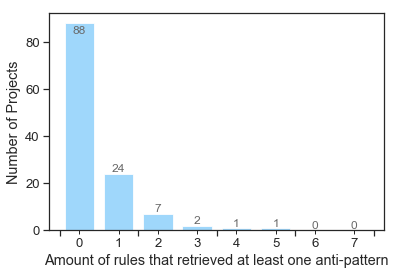

In [22]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set(font_scale=1.2)
plt.figure(figsize=(6,4))
sns.set_style("ticks")

ax = sns.distplot(df['# of Categories'], kde=False, bins=range(0,9), color=COLOR, 
             hist_kws={'rwidth':0.75, 'alpha':ALPHA})

ax.set(xlabel='Amount of rules that retrieved at least one anti-pattern', ylabel='Number of Projects',)

# Annotate Bars
for p in ax.patches:
    if p.get_height() > 50:
        offset = -3
    else:
        offset = +2
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() + offset),
         ha='center', va='center', rotation=0, xytext=(0, 0), textcoords='offset points',fontsize=12, color='dimgray')  #vertical bars


# Hide major tick labels
ax.xaxis.set_major_formatter(ticker.NullFormatter())

# Centralize minor tick labels
ax.xaxis.set_minor_locator(ticker.FixedLocator([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(['0','1','2','3','4','5','6','7', '']))

plt.savefig(os.path.join(folder, '..', 'figs', 'projects-rules-ditribution.pdf'))

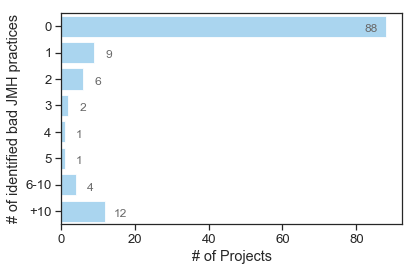

In [23]:
%matplotlib inline
sns.set(font_scale=1.2)
sns.set_style("ticks")

bins = [-1,0,1,2,3,4,5,10,50]

plt.figure(figsize=(6,4))

clrs = 'colorblind'
clrs = 'Blues'

distribution = pd.cut(df['# of AP'], bins=bins).value_counts()
#distribution = distribution / 123 * 100
distribution = distribution[distribution > 0]
ax = sns.barplot(y=distribution.index, x=distribution, color=COLOR, alpha=ALPHA)

for p in ax.patches:
    if p.get_width() > 40:
        offset = -4
    else:
        offset = +4
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width() + offset, p.get_y() + .5),
         ha='center', va='center', rotation=0, xytext=(0, 0), textcoords='offset points',fontsize=12, color='dimgray')  #vertical bars

ax.yaxis.set_major_formatter(ticker.FixedFormatter(['0','1','2','3','4','5','6-10','+10']))
ax.set(ylabel='# of identified bad JMH practices', xlabel='# of Projects',)

plt.tight_layout()

plt.savefig(os.path.join(folder, '..', 'figs', 'projects-ap-ditribution.pdf'))

In [29]:
pd.cut(df['# of AP'], bins=bins).value_counts()
123 - 88

35

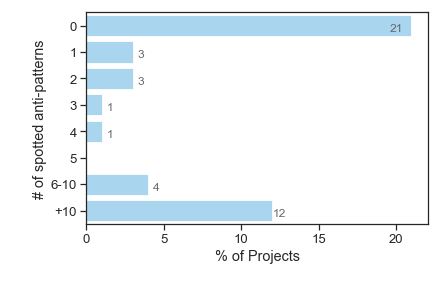

In [19]:
%matplotlib inline
sns.set(font_scale=1.2)
sns.set_style("ticks")

bins = [-1,0,1,2,3,4,5,10,50]

plt.figure(figsize=(6,4))

clrs = 'colorblind'
clrs = 'Blues'

distribution = pd.cut(large_df['# of AP'], bins=bins).value_counts()
#distribution = distribution / 45 * 100
distribution = distribution[distribution > 0]
ax = sns.barplot(y=distribution.index, x=distribution, color=COLOR, alpha=ALPHA)

for p in ax.patches:
    if p.get_width() > 20:
        offset = -1
    else:
        offset = +0.5
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width() + offset, p.get_y() + .5),
         ha='center', va='center', rotation=0, xytext=(0, 0), textcoords='offset points',fontsize=12, color='dimgray')  #vertical bars

ax.yaxis.set_major_formatter(ticker.FixedFormatter(['0','1','2','3','4','5','6-10','+10']))
ax.set(ylabel='# of spotted anti-patterns', xlabel='% of Projects',)

plt.tight_layout()

plt.savefig(os.path.join(folder, '..', 'figs', 'projects-ap-ditribution-large.pdf'))

In [21]:
distribution / distribution.sum()

(-1, 0]    0.47
(10, 50]   0.27
(5, 10]    0.09
(1, 2]     0.07
(0, 1]     0.07
(3, 4]     0.02
(2, 3]     0.02
Name: # of AP, dtype: float64

### Analysis per Category of Anti-pattern

In [221]:
category_df = pd.DataFrame(columns=['Total', '# of Projects'])

pd.options.display.float_format = '{:.2f}'.format

for ap in anti_patterns:
    total = df[ap].sum()
    projects = len(df[df[ap] > 0])
    category_df.loc[ap] = [total, projects]
    
category_df['% of Projects'] = category_df['# of Projects'] / len(df) * 100

print(category_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Total &  \# of Projects &  \% of Projects \\
\midrule
INVO &  82.00 &          10.00 &           8.13 \\
FORK &   7.00 &           3.00 &           2.44 \\
RETU &  89.00 &          15.00 &          12.20 \\
FINA &  25.00 &           9.00 &           7.32 \\
LOOP & 128.00 &          16.00 &          13.01 \\
\bottomrule
\end{tabular}



### Selected Projects

In [223]:
selected_projects = [
    'netty',
    'druid',
    'h2o-3',
    'pgdbc',
    'oopsla15-artifact',
    'benchmark-arraycopy',
    'logging-log4j2',
    'caffeine',
    'gs-collections',
    'hppc'
]

df_selected = analyzed[analyzed.index.isin(selected_projects)]
pd.options.display.float_format = '{:2.0f}'.format
df_selected = df_selected[anti_patterns].apply(pd.to_numeric)

print(df_selected[anti_patterns].to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  INVO &  FORK &  RETU &  FINA &  LOOP \\
name                &       &       &       &       &       \\
\midrule
netty               &     2 &     0 &    10 &     2 &    14 \\
druid               &     2 &     0 &     0 &     1 &    11 \\
caffeine            &     0 &     0 &     1 &     0 &     0 \\
h2o-3               &    10 &     0 &     0 &     0 &     6 \\
gs-collections      &     0 &     0 &    47 &     0 &     0 \\
hppc                &     0 &     0 &     0 &     0 &     0 \\
logging-log4j2      &     0 &     0 &     9 &     4 &     6 \\
oopsla15-artifact   &    13 &     3 &     4 &     2 &     1 \\
benchmark-arraycopy &     0 &     2 &     0 &     0 &     0 \\
\bottomrule
\end{tabular}



In [224]:
selected = pd.DataFrame(columns=['#1', '#2', '#3'])

for ap in anti_patterns: 
    p = analyzed[analyzed[ap] > 1] # Filter unique cases
    selected.loc[ap] = p[:3].index.values
    
print(selected.to_latex())

\begin{tabular}{llll}
\toprule
{} &      \#1 &                 \#2 &                   \#3 \\
\midrule
INVO &   netty &              druid &                h2o-3 \\
FORK &  pgjdbc &  oopsla15-artifact &  benchmark-arraycopy \\
RETU &   netty &     gs-collections &       logging-log4j2 \\
FINA &   netty &     logging-log4j2 &          jmh-samples \\
LOOP &   netty &              druid &                h2o-3 \\
\bottomrule
\end{tabular}



### Correlation between # Benchmarks and Amount of Antipatterns found

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.6901351300513728, 1.0521758655102565e-18)

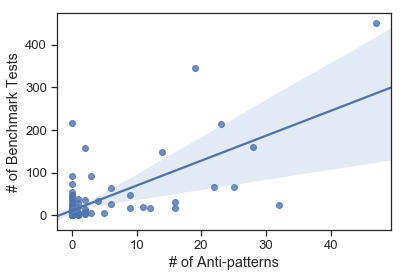

In [254]:
from scipy import stats

all_antipatterns = ['INVO', 'FORK', 'RETU', 'LOOP', 'FINA']

df['# of Anti-patterns'] = df[all_antipatterns].apply(sum, axis=1)

ax = sns.regplot(x="# of Anti-patterns", y="Benchs", data=df)
ax.set(xlabel='# of Anti-patterns', ylabel='# of Benchmark Tests')
plt.savefig(os.path.join(folder, '..', 'figs', 'correlation-bench-ap.pdf'))

stats.pearsonr(df['Benchs'].values, df['# of Anti-patterns'].values)

